In [14]:
from collections import defaultdict
from typing import Tuple
import logging
import sys


import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import datamol as dm
import splito
import optuna
from yellowbrick.regressor import ResidualsPlot, PredictionError


from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
def mask_nan(y_true, y_pred):
    mask = ~np.isnan(y_true)
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]
    return y_true, y_pred

def eval_admet(preds: dict[str, list], refs: dict[str, list]) -> Tuple[dict[str, float], np.ndarray]:
    """
    Eval ADMET targets with MAE for pre-log10 transformed targets (LogD) and MALE  (MAE on log10 transformed dataset) on non-transformed data

    This provides a "relative" error metric that will not be as sensitive to the large outliers with huge errors. This is sometimes known as MALE.

    Parameters
    ----------
    preds : dict[str, list]
        Dictionary of predicted ADMET values.
    refs : dict[str, list]
        Dictionary of reference ADMET values.

    Returns
    -------
    dict[str, float]
        Returns a dictonary of summary statistics
    """
    keys = {
        "MLM",
        "HLM",
        "KSOL",
        "LogD",
        "MDR1-MDCKII",
    }
    # will be treated as is
    logscale_endpts = {"LogD"}

    collect = defaultdict(dict)

    for k in keys:
        if k not in preds.keys() or k not in refs.keys():
            raise ValueError("required key not present")

        ref, pred = mask_nan(refs[k], preds[k])

        if k in logscale_endpts:
            # already log10scaled
            mae = mean_absolute_error(ref, pred)
            r2 = r2_score(ref, pred)
        else:
            # clip to a detection limit
            epsilon = 1e-8
            pred = np.clip(pred, a_min=epsilon, a_max=None)
            ref = np.clip(ref, a_min=epsilon, a_max=None)

            # transform both log10scale
            pred_log10s = np.log10(pred)
            ref_log10s = np.log10(ref)

            # compute MALE and R2 in log space
            mae = mean_absolute_error(ref_log10s, pred_log10s)
            r2 = r2_score(ref_log10s, pred_log10s)

        collect[k]["mean_absolute_error"] = mae
        collect[k]["r2"] = r2

    # compute macro average MAE
    macro_mae = np.mean([collect[k]["mean_absolute_error"] for k in keys])
    collect["aggregated"]["macro_mean_absolute_error"] = macro_mae

    # compute macro average R2
    macro_r2 = np.mean([collect[k]["r2"] for k in keys])
    collect["aggregated"]["macro_r2"] = macro_r2

    return collect

In [4]:
train_idx = np.load('data/train_idx.npy')
test_idx = np.load('data/test_idx.npy')
data = pd.read_csv('data/train_data.csv')
train = data.iloc[train_idx, :].copy()
test = data.iloc[test_idx, :].copy()

train.shape, test.shape

((348, 6), (86, 6))

In [5]:
class YTransform:
    def __init__(self):
        self.scaler = sk.preprocessing.MinMaxScaler(feature_range=(1, 100))
        self.cols = ['MLM', 'HLM', 'D', 'KSOL', 'MDR1-MDCKII']
        self.missing_ix_by_col = {}

    def fit(self,df_train_Y):
        Y = self._col_select(df_train_Y)
        self.scaler.fit(Y)

    
    def _col_select(self, Y):
        Y.loc[:, 'D'] = np.exp(Y['LogD'].values)
        return Y.loc[:,self.cols].values

    def transform(self, df_Y): 
        Y = self._col_select(df_Y)
        df = pd.DataFrame(np.log(self.scaler.transform(Y)), columns=self.cols)
        return df
    
    def inverse_transform(self, trans_Y, col):
        shape= (trans_Y.shape[0], len(self.cols))
        ix = np.where(np.array(self.cols)==col)[0]


        df = pd.DataFrame(np.zeros(shape), columns=self.cols)
        df.loc[:, col] = trans_Y
        Y =  self.scaler.inverse_transform(np.exp(df.values))
        
        return pd.DataFrame({col: Y[:, ix].flatten()})
        
    
    def not_nan(self, X, df_Y, col):
        ix = ~df_Y[col].isna()
        
        return X[ix, :], df_Y.loc[ix, col].values
        

    
class FPTransform:
    def __init__(self):
        self.fps = None
        self.fps_std = None
        self.std_to_ix = {} 

    def fit(self, X): 
        self.fps = self._fps(X)
        self.fps_std = np.std(self.fps,axis=0)

    def _fps(self, X):
        return np.array([dm.to_fp(dm.to_mol(smi)) for smi in X.CXSMILES])

    def transform(self, X, std_cutoff=0): 
        informative_ix = np.where(self.fps_std > std_cutoff )[0]
        fps = self._fps(X)
        self.std_to_ix[std_cutoff] = informative_ix
        return fps[:, informative_ix]




In [7]:
xtrans = FPTransform()
cutoff = 0

xtrans.fit(train)
train_X = xtrans.transform(train, std_cutoff=cutoff)
test_X = xtrans.transform(test, std_cutoff=cutoff)

ytrans = YTransform()
ytrans.fit(train)
train_Y_df = ytrans.transform(train)
test_Y_df = ytrans.transform(test)

In [8]:
random_state = 92038745

def objective(trial, target='KSOL'):
    learning_rate = trial.suggest_float("learning_rate", low=1e-3, high=1, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 500, step=10)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 256, step=2)
    max_depth = trial.suggest_int("max_depth", 3, 16)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    l2_regularization = trial.suggest_float("l2_regularization", 1e-6, 1.0, log=True)
    max_bins = trial.suggest_int("max_bins", 32, 255)


    # Define the model
    model = sk.ensemble.HistGradientBoostingRegressor(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        l2_regularization=l2_regularization,
        max_bins=max_bins,
        random_state=random_state
    )
    train_X_target, train_Y_target = ytrans.not_nan(train_X, train_Y_df, col=target)
    test_X_target, test_Y_target = ytrans.not_nan(test_X, test_Y_df, col=target)

    # Evaluate using cross-validation
    model.fit(train_X_target, train_Y_target)
    predict_Y_target = model.predict(test_X_target)
    score = mean_absolute_error(predict_Y_target, test_Y_target)
    return score


In [9]:
# Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "fp_gbm"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

target = 'KSOL'

from optuna.samplers import TPESampler

sampler = TPESampler(n_startup_trials=100, seed=random_state)
study = optuna.create_study(study_name=target, 
                            storage=storage_name, 
                            direction='minimize', 
                            load_if_exists=True)
study.optimize(objective, n_trials=150)

[I 2025-02-14 20:17:17,429] A new study created in RDB with name: KSOL
[I 2025-02-14 20:17:20,958] Trial 0 finished with value: 1.0000407359333474 and parameters: {'learning_rate': 0.001864783444688107, 'max_iter': 270, 'max_leaf_nodes': 12, 'max_depth': 10, 'min_samples_leaf': 15, 'l2_regularization': 8.59013670469001e-06, 'max_bins': 245}. Best is trial 0 with value: 1.0000407359333474.
[I 2025-02-14 20:17:22,133] Trial 1 finished with value: 1.1645477583549875 and parameters: {'learning_rate': 0.001227648276301505, 'max_iter': 90, 'max_leaf_nodes': 54, 'max_depth': 11, 'min_samples_leaf': 15, 'l2_regularization': 0.00027566066293610857, 'max_bins': 54}. Best is trial 0 with value: 1.0000407359333474.
[I 2025-02-14 20:18:05,141] Trial 2 finished with value: 0.7866560958363359 and parameters: {'learning_rate': 0.0037229569129277433, 'max_iter': 280, 'max_leaf_nodes': 214, 'max_depth': 13, 'min_samples_leaf': 1, 'l2_regularization': 0.02200166746285564, 'max_bins': 235}. Best is trial 

In [11]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study)


In [12]:
plot_param_importances(study)


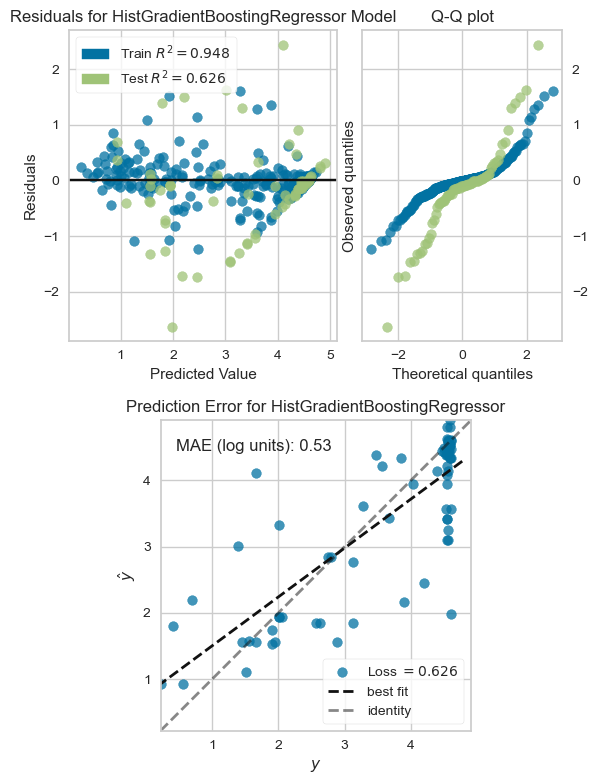

In [25]:
train_X_target, train_Y_target = ytrans.not_nan(train_X, train_Y_df, col=target)
test_X_target, test_Y_target = ytrans.not_nan(test_X, test_Y_df, col=target)



model = sk.ensemble.HistGradientBoostingRegressor(**study.best_params)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

visualizer = ResidualsPlot(model, qqplot=True, hist=False, ax=axes[0])
visualizer.fit(train_X_target, train_Y_target)
visualizer.score(test_X_target, test_Y_target)
test_Y_hat = visualizer.predict(test_X_target)
visualizer.finalize()

predictions = PredictionError(visualizer.estimator, ax=axes[1])
score = predictions.score(test_X_target, test_Y_target)
test_Y_hat = model.predict(test_X_target)

mae = mean_absolute_error(test_Y_target, test_Y_hat)

predictions.finalize()
axes[1].annotate(text=f'MAE (log units): {mae:4.2f}', xy=(0.05, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.savefig(f'{target}_{study_name}_optimized.png')
